In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.89.1
    Uninstalling fastapi-0.89.1:
      Successfully uninstalled fastapi-0.89.1


In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
import glob
import os
import gc
from torchvision.transforms import Resize
from torchvision.transforms.functional import pil_to_tensor
from torchvision.io import read_image
from xml.etree import ElementTree as et
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split, DataLoader

from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from albumentations.pytorch.transforms import ToTensorV2
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np


import torchmetrics
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelSummary
from lightning.pytorch.tuner.tuning import Tuner

import albumentations as A
from torchvision.ops import box_iou
from torchvision.models.detection._utils import Matcher


from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
from sklearn.model_selection import train_test_split
from lightning.pytorch.callbacks import Callback
from IPython.display import clear_output

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from functools import partial

from torchvision.utils import draw_bounding_boxes
from torchvision.ops.boxes import nms

In [3]:
# -------------------
# Step 1: Define your custom dataset
# -------------------

class CustomDataset(Dataset):
    def __init__(self,
                 base_dir, # путь к директории нашего датасета
                 data_type, # папка с типом данных (тренировачные или тестовые)
                 width_resize, # желаемая ширина изображения
                 height_resize, # желаемая высота изображения
                 classes, # список классов
                 transforms=None # можно добавить трансформации которые будут осуществляться с данными. Например отражения, повороты, масштабирование и тп.
                 ):
        self.base_dir = base_dir
        self.data_type = data_type
        self.height = height_resize
        self.width = width_resize
        self.classes = classes
        self.transforms = transforms

        # получаем все пути изображений в сортированном виде
        self.image_paths = glob.glob(f"{self.base_dir + '/' + self.data_type + '/'}/*.jpeg")
        self.images = [image_path.split('/')[-1] for image_path in self.image_paths]
      
    def __getitem__(self, idx):
      image_path = self.base_dir + '/' + self.data_type + '/' + self.images[idx] # путь к изображению по конкретному индексу
      image = Image.open(image_path).convert('RGB') # открываем изображение с помощью PIL
      image_width, image_height = image.size
      if ((image_width != self.width) and (image_height !=self.height)):
        image = image.resize((self.width, self.height), resample=4) # меняем размер изображения если необходимо (используется высококачественный алгортим Lanczos)
      annotation_path = self.base_dir + '/annotations/xmls/' + self.images[idx][:-5] + '.xml' # путь к аннотации данного изображения

      boxes = [] # здесь будем хранить боксы данного изображения
      labels = [] # здесь будет храниться класс каждого бокса
      # Работаем с xlm файлом и его структурой.
      tree = et.parse(annotation_path) 
      root = tree.getroot()
      for section in root.findall('object'):
        labels.append(self.classes.index(section.find('name').text)) # вычленяем имя класса найденного бокса и преобразуем в соответствующий числовой индекс и сохраняем его
        # xmin = left corner x-coordinates
        xmin = int(float(section.find('bndbox').find('xmin').text))
        # xmax = right corner x-coordinates 
        xmax = int(float(section.find('bndbox').find('xmax').text))
        # ymin = left corner y-coordinates
        ymin = int(float(section.find('bndbox').find('ymin').text))
        # ymax = right corner y-coordinates
        ymax = int(float(section.find('bndbox').find('ymax').text))
  
        # по необходимости изменяем размер бокса если меняем размер самого изображения
        xmin = (xmin/image_width)*self.width
        xmax = (xmax/image_width)*self.width
        ymin = (ymin/image_height)*self.height
        ymax = (ymax/image_height)*self.height

        boxes.append([xmin, ymin, xmax, ymax]) # сохраняем координаты конкретного бокса

      
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)
      image_id = torch.tensor([idx])
      
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # считаем площади боксов (это только для instance segmentation)
      iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64) # отсутствует маска объекта внутри бокса (это только для instance segmentation)
      target = {} # формируем целевое значение для модели
      target["boxes"] = boxes
      target["labels"] = labels
      target["area"] = area
      target["iscrowd"] = iscrowd
      target["image_id"] = image_id
      
      if self.transforms:
        sample = self.transforms(image=np.array(image), bboxes=target["boxes"], labels=target["labels"])
        image = sample["image"]/255
        if(len(sample["bboxes"]) == 0):
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros(0, dtype=torch.int64)
        else:
            target["boxes"] = torch.as_tensor(sample["bboxes"], dtype=torch.float32)
      else:
        image = pil_to_tensor(image)/255
      return image, target
    
    def __len__(self):
        return len(self.images)

In [4]:
# -------------------
# Step 2: Define train, validation, test data in DataModule
# -------------------

class DataModule(pl.LightningDataModule):
    def __init__(self,
                 base_dir,
                 width_resize,
                 height_resize,
                 classes,
                 batch_size,
                 transforms=None):
      super().__init__()
      self.train_transforms = train_transforms = A.Compose([A.HorizontalFlip(p=0.75),
                                                          A.ShiftScaleRotate(shift_limit=0.05, scale_limit=(0, 0.15), rotate_limit=0, p=0.5),
                                                          A.HueSaturationValue(hue_shift_limit=(-10, 10), sat_shift_limit=(-15, 15), val_shift_limit=(-15, 15), p=0.75),
                                                          ToTensorV2()
                                                          ],bbox_params={'format': 'pascal_voc',
                                                                         'label_fields': ['labels']})
      self.test_val_transforms = None
      self.transforms = transforms
      self.base_dir = base_dir
      self.height = height_resize
      self.width = width_resize
      self.classes = classes
      self.batch_size = batch_size
      
    def setup(self, stage=None):                                                
      train_dataset = CustomDataset(self.base_dir, 'train_data', self.width, self.height, self. classes, self.train_transforms)
      val_dataset = CustomDataset(self.base_dir, 'train_data', self.width, self.height, self. classes, self. test_val_transforms)
      self.test_data = CustomDataset(self.base_dir, 'test_data', self.width, self.height, self. classes, self.test_val_transforms)
      indices = torch.randperm(len(train_dataset))
      train_set_size = int(len(train_dataset) * 0.8)
      valid_set_size = len(train_dataset) - train_set_size
      self.train_data = torch.utils.data.Subset(train_dataset, indices[:-valid_set_size])
      self.val_data = torch.utils.data.Subset(val_dataset, indices[-valid_set_size:])

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=2, collate_fn=self.collate_fn) # change num_workers if you work with gpu to speed up training
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=2, collate_fn=self.collate_fn) # change num_workers if you work with gpu to speed up training
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False, num_workers=2, collate_fn=self.collate_fn)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """
        images = list()
        targets = list()

        for i, t in batch:
            images.append(i)
            targets.append(t)
        images = torch.stack(images, dim=0)

        return images, targets

In [11]:
# --------------------------------
# Step 3: Build your network
# --------------------------------

def create_model(num_classes):
    # FasterRCNN ResNet50
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    """
    # FasterRCNN MobileNetV3
    """
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    """
    # RetinaNet ResNet50
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights='DEFAULT')
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=partial(torch.nn.GroupNorm, 32)
    )
    return model

In [6]:
# --------------------------------
# Step 3: Compile your model of your network
# --------------------------------

class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model:torch.nn.Module,
                 optimizer:torch.optim,
                 learning_rate:float):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, x):
        self.model.eval()
        return self.model(x)
    
    def configure_optimizers(self):
        train_optimizer = self.optimizer(self.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=0.0005);
        train_scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=train_optimizer, mode="min", factor=0.5, patience=2, min_lr=5e-6),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"
        }
        return [train_optimizer], [train_scheduler];

    def training_step(self, batch, batch_idx):
        images, targets = batch
        # fasterrcnn принимает изображения и целевую переменную в процессе обучения и выдаёт словарь ошибок
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch        
        # fasterrcnn принимает только изображения в процессе валидации и не возвращает ошибки, а возвращает предсказания, поэтому используем метод eval_forward написанный ниже (взято из stackoverflow)
        pred = self.forward(images)
        ious = [self._evaluate_iou(targets[i], pred[i]) for i in range(len(targets))]
        iou = sum(ious) / len(ious)
        self.log('val_iou-score', iou, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.model.train()
        with torch.no_grad():
            loss_dict = self.model(images, targets)
            val_loss = sum(loss for loss in loss_dict.values())
            self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        images, targets = batch
        pred = self.forward(images)
        ious = [self._evaluate_iou(targets[i], pred[i]) for i in range(len(targets))]
        iou = sum(ious) / len(ious)
        self.log('test_iou-score', iou, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.model.train()
        with torch.no_grad():
            loss_dict = self.model(images, targets)
            test_loss = sum(loss for loss in loss_dict.values())
            self.log('test_loss', test_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return test_loss

    def _evaluate_iou(self, target, pred):
        if pred['boxes'].shape[0] == 0:
            # no box detected, 0 IOU
            return torch.tensor(0.0, device=pred['boxes'].device)
        return box_iou(target['boxes'], pred['boxes']).max()

In [7]:
# -------------------
# Step 4: Init your DataModule
# -------------------

base_dir = '/kaggle/input/d/konstantinvetrov/wildfire-v2/day_time_wildfire_v2'
width = 640
height = 480
classes = ['background', 'smoke']
batch_size = 32
data_module = DataModule(base_dir=base_dir, width_resize=width, height_resize=height, classes=classes, batch_size=batch_size, transforms=None)

In [8]:
class TrainHistory(Callback):
    def __init__(self):
        self.history = {"val_loss": np.array([]), "val_iou-score": np.array([]), "train_loss_epoch": np.array([])}

    def on_train_epoch_end(self, trainer, module):
        logs = trainer.logged_metrics
        self.history["val_iou-score"] = np.append(self.history["val_iou-score"], logs["val_iou-score"].cpu())
        self.history["val_loss"] = np.append(self.history["val_loss"], logs["val_loss"].cpu())
        self.history["train_loss_epoch"] = np.append(self.history["train_loss_epoch"], logs["train_loss_epoch"].cpu())

In [9]:
# -------------------
# Step 5: Init callbacks: init ModelCheckpoint for monitoring 'val_loss', init earlystopping to stop our training when results don't improve
# -------------------
checkpoint_callback_loss = ModelCheckpoint(filename='best_model_loss', monitor="val_loss", mode='min')
checkpoint_callback_iou = ModelCheckpoint(filename='best_model_iou', monitor="val_iou-score", mode='max')
lr_monitor = LearningRateMonitor(logging_interval="epoch")
train_history_callback = TrainHistory()
callbacks = [checkpoint_callback_loss, checkpoint_callback_iou, train_history_callback, lr_monitor]

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(list(range(len(train_history_callback.history["val_loss"]))), train_history_callback.history["val_loss"], label='Val loss')
plt.plot(list(range(len(train_history_callback.history["val_iou-score"]))), train_history_callback.history["val_iou-score"], label='IoU score')
plt.plot(list(range(len(train_history_callback.history["train_loss_epoch"]))), train_history_callback.history["train_loss_epoch"], label='Train loss')
plt.grid()
plt.legend()
plt.show()

In [12]:
# -------------------
# Step 6: Init your model and its trainer with callbacks
# -------------------

device = 'cuda'

num_classes = len(classes)
network = create_model(num_classes=num_classes)
optimizer = torch.optim.SGD
learning_rate = 0.003

model = ModelCompilation(network, optimizer, learning_rate)
trainer = pl.Trainer(callbacks=callbacks, precision='32', accelerator=device, devices="auto", max_epochs=50)
# fast debug mode for your model
#trainer = pl.Trainer(callbacks=callbacks, precision='32', accelerator=device, devices="auto", fast_dev_run=5)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth


  0%|          | 0.00/146M [00:00<?, ?B/s]

In [13]:
model = model.load_from_checkpoint("/kaggle/input/best-model/best_model.ckpt")
torch.save(model.model.state_dict(), 'fasterrcnn.pth')

In [ ]:
network = create_model(num_classes=num_classes)
network.load_state_dict(torch.load('fasterrcnn.pth'))

In [ ]:
# -------------------
# Step 6: Train your model
# -------------------
torch.cuda.empty_cache()
gc.collect()
trainer.fit(model, datamodule=data_module)

In [ ]:
# -------------------
# Step 7: Find optimal batch_size and change it
# -------------------
tuner = Tuner(trainer)
batch_size_finder = tuner.scale_batch_size(model=model, mode="binsearch", datamodule=data_module)
print('The biggest batch_size that we can use is: ' + str(batch_size_finder))

In [ ]:
# -------------------
# Step 8: Find optimal learning rate and change it
# -------------------
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model=model, datamodule=data_module)
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
lr_suggested = lr_finder.suggestion()
print(lr_suggested)

In [19]:
# -------------------
# Step 9: Test your model on specific example
# -------------------
predictions = trainer.test(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_iou-score       │    0.19158639013767242    │
│         test_loss         │    0.19884639978408813    │
└───────────────────────────┴───────────────────────────┘

In [21]:
def draw_predict(data_idx, iou_threshold=0.1, prob_threshold=0.7):
    test_data = CustomDataset(base_dir, 'test_data', width, height, classes, None)
    val_image, targets = test_data.__getitem__(data_idx) # загружаем из валидационного набора данных одно нормализованное изображение и его целевые данные
    model.eval()  # включаем в режим тестирования
    predict_dict = model.forward([val_image]) # предсказываем для текущего изображения boxes, labels и scores в формате dict

    bbox = predict_dict[0]['boxes'] # достаём боксы для отображения
    scores = predict_dict[0]['scores'] # достаём метрику для полученных боксов (вероятность принадлежности к объекту)

    bbox_idx = nms(bbox, scores, iou_threshold).detach().cpu().numpy() # non maximum suppression объединяет похожие дублирующиеся рамки на основе их взаимного пересечения
    val_image = torch.as_tensor(val_image*255, dtype=torch.uint8) # делаем обратную нормализацию в пределы от 0 до 255 и преобразуем в uint8
    img=draw_bounding_boxes(val_image, bbox[bbox_idx], width=1, colors=(255,255,0)) # отображаем боксы на наше изображение
    img=draw_bounding_boxes(img, targets['boxes'], width=1, colors=(255,0,0))
    img = torchvision.transforms.ToPILImage()(img) # преобразуем в PIL изображение
    plt.imshow(img)

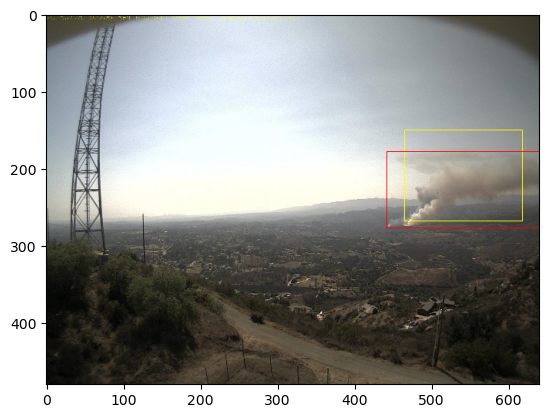

In [22]:
draw_predict(1)